Data shape: (360, 30, 30)
Hs range: 0.00 to 4.38
Tm range: 0.00 to 5.36


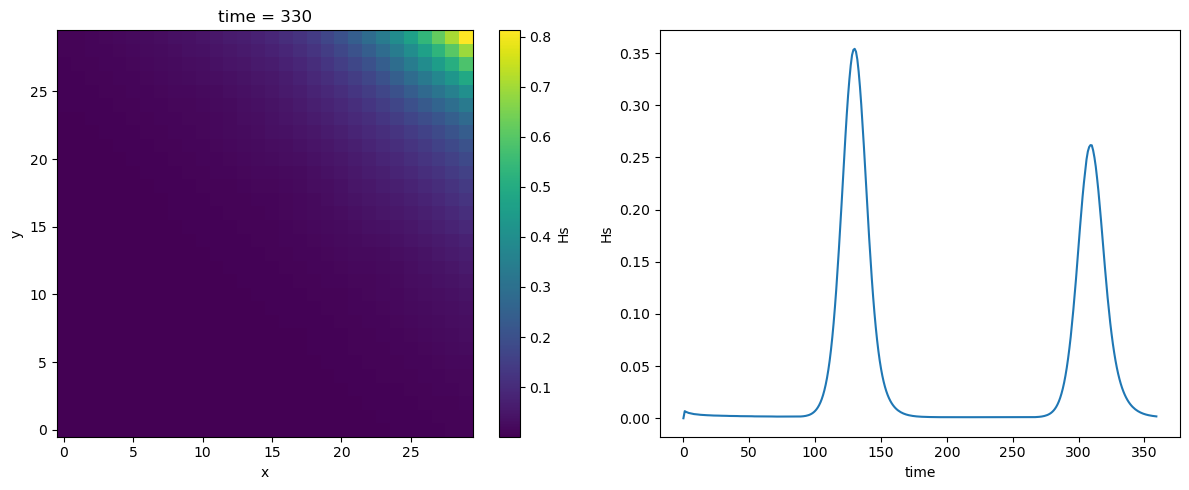

In [41]:
import numpy as np
import pandas as pd
import xarray as xr
import os

nx, ny = 30, 30
nsteps = 360
diagnostic_dir = "/home/yothunder/fort/wvmod/output/diag"

Hs_all = np.zeros((nsteps, ny, nx))
Tm_all = np.zeros((nsteps, ny, nx))

def clean_data(filename):
    """Clean and validate diagnostic data file"""
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
        
        clean_lines = []
        for line in lines:
            if '*' not in line and line.strip():
                try:
                    values = [float(val) for val in line.split()]
                    if len(values) == 2:  # Hs and Tm
                        clean_lines.append(values)
                except ValueError:
                    continue
        
        if not clean_lines:
            print(f"Warning: No valid data in {filename}")
            return None
            
        return np.array(clean_lines)
    
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        return None

for n in range(nsteps):
    filename = os.path.join(diagnostic_dir, f"diagnostics_{n:04d}.txt")
    if os.path.exists(filename):
        data = clean_data(filename)
        if data is not None and len(data) == nx * ny:
            Hs_all[n] = data[:, 0].reshape((ny, nx))
            Tm_all[n] = data[:, 1].reshape((ny, nx))
        else:
            print(f"Warning: Invalid data shape in {filename}")

time = np.arange(nsteps)
x = np.arange(nx)
y = np.arange(ny)

ds = xr.Dataset(
    {
        "Hs": (("time", "y", "x"), Hs_all),
        "Tm": (("time", "y", "x"), Tm_all),
    },
    coords={
        "time": time,
        "x": x,
        "y": y,
    },
    attrs={
        "title": "Diagnostics output from wave model",
        "description": "3D dataset of Hs and Tm over time and space"
    }
)

print(f"Data shape: {ds.Hs.shape}")
print(f"Hs range: {ds.Hs.min().item():.2f} to {ds.Hs.max().item():.2f}")
print(f"Tm range: {ds.Tm.min().item():.2f} to {ds.Tm.max().item():.2f}")

ds

import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
ds.Hs.isel(time=330).plot(cmap='viridis', ax=ax[0])
ds.mean(dim=['x', 'y']).Hs.plot(ax=ax[1])
plt.tight_layout()

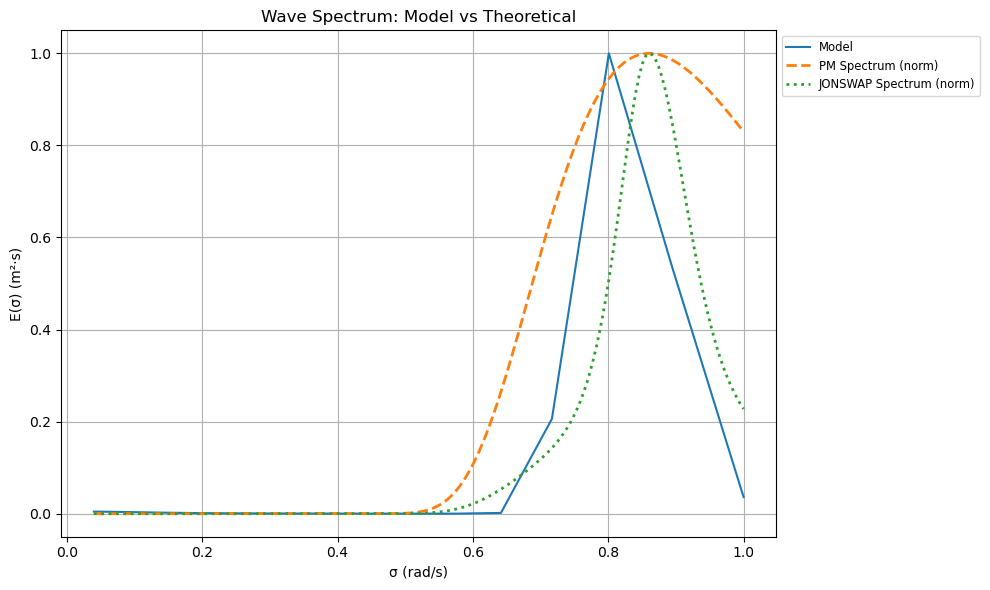

In [49]:
import matplotlib.pyplot as plt
import os

import re

def fix_scientific_notation(filename):
    """Fix numbers like 8.5022-100 to 8.5022E-100 in a file and return as numpy array."""
    with open(filename, 'r') as f:
        lines = f.readlines()
    fixed_lines = []
    for line in lines:
        # Insert 'E' before minus/plus if not already present (and not at start)
        fixed_line = re.sub(r'(\d)([-+]\d{2,})', r'\1E\2', line)
        fixed_lines.append(fixed_line)
    from io import StringIO
    return np.loadtxt(StringIO(''.join(fixed_lines)))

diagnostic_dir = '/home/yothunder/fort/wvmod/output/spc'
files = sorted([os.path.join(diagnostic_dir, f) for f in os.listdir(diagnostic_dir)])
spectra = [fix_scientific_notation(f) for f in files]
sigma_model = spectra[0][:, 0]
E_models = [s[:, 1] for s in spectra]

# Define PM and JONSWAP spectra
def pm_spectrum(sigma, u10, alpha=8.1e-3, beta=0.74, g=9.81):
    return alpha * g**2 * sigma**-5 * np.exp(-beta * (g / (sigma * u10))**4)

def jonswap_spectrum(sigma, u10, gamma=5, g=9.81):
    alpha = 0.076 * (u10**2 / g)**0.22
    sigma_p = 0.877 * g / u10
    sigma_sigma = np.where(sigma < sigma_p, 0.07, 0.09)
    r = np.exp(-((sigma - sigma_p)**2) / (2 * sigma_sigma**2 * sigma_p**2))
    pm = alpha * g**2 * sigma**-5 * np.exp(-1.25 * (sigma_p / sigma)**4)
    return pm * gamma**r

# Reference spectra
u10_val = 10.0  # m/s
sigma_ref = np.linspace(min(sigma_model), max(sigma_model), 200)
E_pm = pm_spectrum(sigma_ref, u10_val)
E_jonswap = jonswap_spectrum(sigma_ref, u10_val)

# Plot
plt.figure(figsize=(10, 6))
# for i, E in enumerate(E_models):
#     E_norm = E / np.max(E) if np.max(E) > 0 else E
#     plt.plot(sigma_model, E_norm, label=f"Model t={i+1}", linewidth=1.5)

norm = True
if norm:
    E_avg = np.mean(E_models, axis=0)
    E_avg_norm = E_avg / np.max(E_avg)
    plt.plot(sigma_model, E_avg_norm, label=f"Model", linewidth=1.5)

    E_pm_norm = E_pm / np.max(E_pm)
    E_jonswap_norm = E_jonswap / np.max(E_jonswap)
else:
    E_avg = np.mean(E_models, axis=0)
    E_avg_norm = E_avg
    E_pm_norm = E_pm
    E_jonswap_norm = E_jonswap

plt.plot(sigma_ref, E_pm_norm, '--', label="PM Spectrum (norm)", linewidth=2)
plt.plot(sigma_ref, E_jonswap_norm, ':', label="JONSWAP Spectrum (norm)", linewidth=2)

plt.xlabel("σ (rad/s)")
plt.ylabel("E(σ) (m²·s)")
plt.title("Wave Spectrum: Model vs Theoretical")
plt.grid(True)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()


In [47]:
np.pi*0.1*2

0.6283185307179586